# Convolutional Neural Network Example - 卷积神经网络示例

Build a convolutional neural network with TensorFlow v2.

使用 TensorFlow v2 构建卷积神经网络。

This example is using a low-level approach to better understand all mechanics behind building convolutional neural networks and the training process.

这个示例使用了一种低阶的方法，以更好地理解构建卷积神经网络和训练过程背后的所有机制。

- Author: Aymeric Damien
- Project: https://github.com/aymericdamien/TensorFlow-Examples/

## CNN Overview - 卷积神经网络概述

![CNN](http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/images/fig3.png)

## MNIST Dataset Overview

This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 255. 

这个示例使用了 MNIST 手写数字图片数据集。该数据集包含 60000 个用于训练的示例和 10000 个用于测试的示例。这些数字图片的尺寸已经被标准化，以一个固定大小的图像（28x28 像素）并居中，灰度值从 0 到 255。

In this example, each image will be converted to float32 and normalized to [0, 1].

在这个示例中，每个图像将被转换为 float32 类型的数组，将其灰度值标准化到 [0, 1] 并展平为一个 784 个特征（28*28）的一维数组。

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

More info: http://yann.lecun.com/exdb/mnist/

In [34]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from keras import Model, layers
import numpy as np
import keras._tf_keras.keras.optimizers as optimizers

In [35]:
# MNIST dataset parameters. - 数据集超参数
num_classes = 10 # total classes (0-9 digits). - 总类别数（0-9数字 共10种）

# Training parameters. - 训练超参数
learning_rate = 0.001
training_steps = 200
batch_size = 128
display_step = 10

# Network parameters. - 神经网络超参数
conv1_filters = 32 # number of filters for 1st conv layer. - 第一层卷积层的卷积核数量
conv2_filters = 64 # number of filters for 2nd conv layer. - 第二层卷积层的卷积核数量
fc1_units = 1024 # number of neurons for 1st fully-connected layer. - 第一层全连接层的神经元数量

In [36]:
# Prepare MNIST data. - 准备MNIST数据，以及数据预处理
import keras.api.datasets.mnist as mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Convert to float32.- 转换为 float32 类型（原先为 uint8 类型，代表0~255的灰度值）
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Normalize images value from [0, 255] to [0, 1]. - 将图像值从 [0, 255] 标准化为 [0, 1]
x_train, x_test = x_train / 255., x_test / 255.

In [37]:
# Use tf.data API to shuffle and batch data. - 使用 tf.data API 来打乱 并 分批数据
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [38]:
# Create TF Model. - 创建 TensorFlow 模型
class ConvNet(Model):  # 继承自 keras.Model 类
    # Set layers. - 初始化各层
    def __init__(self):
        super(ConvNet, self).__init__() # 调用父类的初始化方法
        # Convolution Layer with 32 filters and a kernel size of 5.
        # 第一层卷积层，32个卷积核，卷积核大小为5X5，激活函数为relu
        self.conv1 = layers.Conv2D(conv1_filters, kernel_size=5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with kernel size of 2 and strides of 2. 
        # Max池化层，池化核大小为2X2，步长为2。池化层的作用是减少特征图的大小，加速计算
        self.maxpool1 = layers.MaxPool2D(2, strides=2)

        # Convolution Layer with 64 filters and a kernel size of 3.
        # 第二层卷积层，64个卷积核，卷积核大小为3X3，激活函数为relu
        self.conv2 = layers.Conv2D(64, kernel_size=3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with kernel size of 2 and strides of 2. 
        # Max池化层，池化核大小为2X2，步长为2。池化层的作用是减少特征图的大小，加速计算
        self.maxpool2 = layers.MaxPool2D(2, strides=2)

        # Flatten the data to a 1-D vector for the fully connected layer.
        # 将数据展平为一维向量，以便输入全连接层
        self.flatten = layers.Flatten()

        # Fully connected layer. - 全连接层，神经元数量为1024
        self.fc1 = layers.Dense(1024)
        # Apply Dropout (if is_training is False, dropout is not applied).
        # Dropout 层，丢弃率为0.5 （如果未在训练，则不应用dropout）
        # 译者注：Dropout 是指在深度学习网络的训练过程中，对于神经网络单元，按照一定的概率将其暂时从网络中丢弃。
        # 这样做可以减少过拟合，从而提高模型的泛化能力，但是可能会增加训练时间。
        self.dropout = layers.Dropout(rate=0.5)

        # Output layer, class prediction.
        # 输出层，输出类别预测，神经元数量为num_classes、即10个，代表0~9的数字种类的可能性
        self.out = layers.Dense(num_classes)

    # Set forward pass. - 设置前向传播
    def call(self, x, is_training=False):
        x = tf.reshape(x, [-1, 28, 28, 1]) # 这里的四个维度分别是：batch_index, height, width, channels
        x = self.conv1(x) # 输入数据经过第一层卷积层
        x = self.maxpool1(x) # 经过第一层池化层
        x = self.conv2(x) # 经过第二层卷积层
        x = self.maxpool2(x) # 经过第二层池化层
        x = self.flatten(x) # 展平池化后的特征图数据、即reshape成一维向量
        x = self.fc1(x) # 经过全连接层
        x = self.dropout(x, training=is_training) # 经过dropout层
        x = self.out(x) # 输出层
        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            # tf的交叉熵函数要求输入的是未经过softmax的logits，所以这里在预测时使用softmax
            # 译者注: 通常来说, 在训练的时候才需要做 softmax 操作, 因为它可以帮助计算Loss
            # 但是在直接预测的时候, 不需要做 softmax 操作, 只需要 argmax 即可.这里原作者似乎写反了.
            x = tf.nn.softmax(x)
        return x

# Build neural network model. - 创建神经网络模型对象
conv_net = ConvNet()

In [39]:
# Cross-Entropy Loss. - 交叉熵损失函数
# Note that this will apply 'softmax' to the logits. - 注意这里会对预测结果进行softmax操作
def cross_entropy_loss(x, y):
    # Convert labels to int 64 for tf cross-entropy function. - 将标签转换为int64类型，方便计算交叉熵
    y = tf.cast(y, tf.int64)
    # Apply softmax to logits and compute cross-entropy. - 对预测结果进行softmax操作，并计算交叉熵
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    # Average loss across the batch. - 计算这一批训练的平均loss
    return tf.reduce_mean(loss)

# Accuracy metric. - 准确率评估函数
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    # 预测的结果类别 是 预测结果向量 中得分最高的索引（即argmax）
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# Stochastic gradient descent optimizer. - 使用Adam优化器
optimizer = optimizers.Adam(learning_rate)

In [40]:
# Optimization process.  - 优化过程
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation. - 使用梯度带自动计算微分梯度
    with tf.GradientTape() as g:
        # Forward pass. - 前向传播
        pred = conv_net(x, is_training=True)
        # Compute loss. - 计算loss
        loss = cross_entropy_loss(pred, y)
        
    # Variables to update, i.e. trainable variables. - 统合需要更新的变量，即可训练的变量
    trainable_variables = conv_net.trainable_variables

    # Compute gradients. - 计算梯度
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients. - 根据梯度更新权重和偏置参数
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [41]:
# Run training for the given number of steps. - 运行训练，给定训练步数
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values. - 运行优化器更新权重和偏置参数
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0: # 每隔display_step步，打印一次目前的训练结果，可以观察到loss和accuracy的变化
        pred = conv_net(batch_x)
        loss = cross_entropy_loss(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 10, loss: 1.761004, accuracy: 0.867188
step: 20, loss: 1.608447, accuracy: 0.921875
step: 30, loss: 1.576144, accuracy: 0.945312
step: 40, loss: 1.558775, accuracy: 0.937500
step: 50, loss: 1.543637, accuracy: 0.945312
step: 60, loss: 1.558458, accuracy: 0.960938
step: 70, loss: 1.531303, accuracy: 0.945312
step: 80, loss: 1.522263, accuracy: 0.968750
step: 90, loss: 1.532791, accuracy: 0.945312
step: 100, loss: 1.530325, accuracy: 0.960938
step: 110, loss: 1.488683, accuracy: 0.992188
step: 120, loss: 1.489624, accuracy: 0.992188
step: 130, loss: 1.508923, accuracy: 0.968750
step: 140, loss: 1.522424, accuracy: 0.953125
step: 150, loss: 1.495834, accuracy: 0.976562
step: 160, loss: 1.511605, accuracy: 0.960938
step: 170, loss: 1.502015, accuracy: 0.968750
step: 180, loss: 1.496109, accuracy: 0.976562
step: 190, loss: 1.496789, accuracy: 0.984375
step: 200, loss: 1.498211, accuracy: 0.984375


In [42]:
# Test model on validation set. - 在测试集上测试模型
pred = conv_net(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.981900


In [43]:
# Visualize predictions. - 可视化预测结果
import matplotlib.pyplot as plt

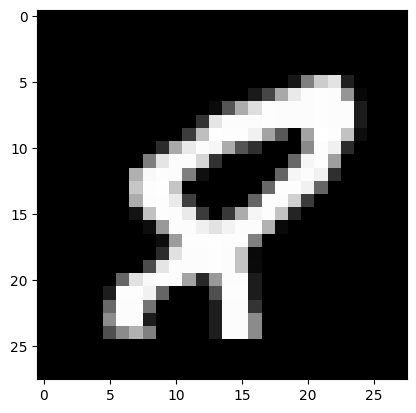

Model prediction: 8


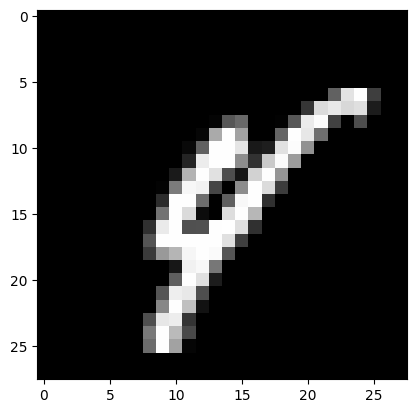

Model prediction: 4


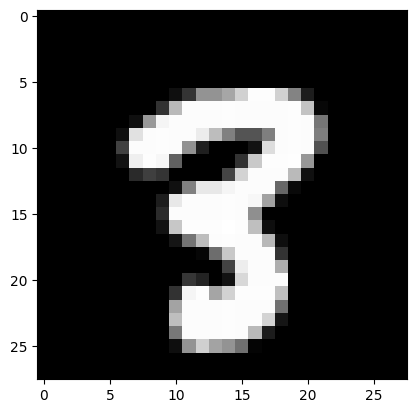

Model prediction: 3


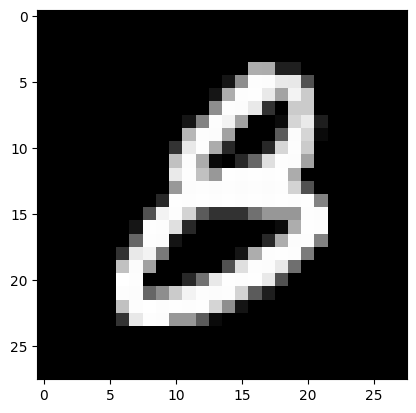

Model prediction: 8


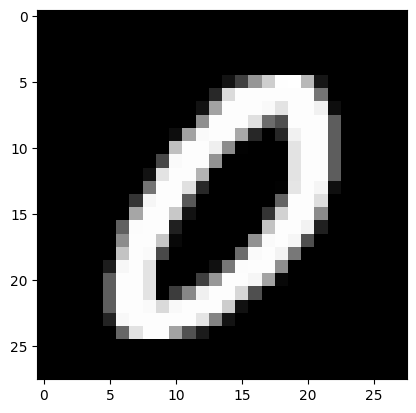

Model prediction: 0


In [45]:
# Predict 5 images from validation set. - 从测试集中预测5张图片
n_images = 5
# test_images = x_test[:n_images]
test_images = x_test[np.random.choice(x_test.shape[0], n_images, replace=False)]
predictions = conv_net(test_images)

# Display image and model prediction. - 显示图片和模型预测结果
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction: %i" % np.argmax(predictions.numpy()[i]))